In [45]:
import pulsestreamer
import pyvisa
import numpy as np
import sys
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np

directory_path = "C:\\Users\\LiLabDesktop\\Desktop\\Sumukh\\LiLabMeasurements\\LiLabMeasurements\\Main"
sys.path.append(directory_path)

import ODMR
reload(ODMR)

from ODMR import plot_this_xy

import confocal_Microscope
# Reload the module
reload(confocal_Microscope)




<module 'confocal_Microscope' from 'C:\\Users\\LiLabDesktop\\Desktop\\Sumukh\\LiLabMeasurements\\LiLabMeasurements\\Main\\confocal_Microscope.py'>

In [46]:
pulsestreamer_ip = '169.254.8.2'
ps = pulsestreamer.PulseStreamer(pulsestreamer_ip)
ps.reset()

rm = pyvisa.ResourceManager()
sg386 = rm.open_resource('GPIB0::27::INSTR')
sg386.write('ENBR 1')

Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 169.254.8.2
Pulse Streamer 8/2 firmware: v1.6.2
Client software: v1.7.0
Your client software is more up to date than the Pulse Streamer 8/2 firmware. We recommend updating the firmware of your Pulse Streamer 8/2.
For detailed information visit https://www.swabianinstruments.com/pulse-streamer-8-2/downloads/ or contact support@swabianinstruments.com


8

In [127]:
confocal_parameters = {
'samples_per_axis' : 201,
'scale' : 8,
'count_time (ms)': 10, 
'LED': False,
'reset': True
}

x,y = confocal_parameters['samples_per_axis']//2, confocal_parameters['samples_per_axis']//2

# confocal.close()


confocal = confocal_Microscope.confocal_Microscope(ps = ps)
# conf_data = confocal.perform_2d_scan(confocal_parameters)
# confocal.close()

In [47]:
odmr_config = {
    # Measurement parameters
    'scale': 8,
    'samples_per_axis': 201,
    'position':[80, 175], # [x,y] position to fix the beam at
    'freq': 1.69e9, # in Hz. 
    'mw_power': -14, # in dBm
    'num_avgs':1,

    'ODMR_Peakfinder': False, # If True, runs a peakfinder before every frequency point
    'peakfinder_window': 3, # Size of the window to search for peak in peakfinder
    'peakfinder_check_step': 1000,
    
    
    # Other parameters
    'pulse_sequence': 'cw_odmr',
    'aomvolt': 0.5,
    'pulsenum': 3000,
    'count_t': 0.1*1e6,  # All times are in NANOSeconds!!!
    'separation_t': 0.02*1e6,
    'addl_t': 0.01*1e6,
    'wait_t': 0.01*1e6,
    'seqplot': False,
}


odmr = ODMR.ODMR(odmr_config, ps=ps, sg386=sg386, rm=rm)

freqs = np.linspace(1.4e9, 1.9e9, num = 51)
# freq_range, avg_contrast, all_contrast, avg_counts, all_counts = odmr.run_frequency_sweep(freqs)

In [97]:
print(odmr.config)

{'scale': 8, 'samples_per_axis': 201, 'position': [80, 175], 'freq': 1690000000.0, 'mw_power': -14, 'num_avgs': 3, 'ODMR_Peakfinder': False, 'peakfinder_window': 3, 'peakfinder_check_step': 1000, 'pulse_sequence': 'cw_odmr', 'aomvolt': 0.5, 'pulsenum': 3000, 'count_t': 100000.0, 'separation_t': 20000.0, 'addl_t': 10000.0, 'wait_t': 10000.0, 'seqplot': False}


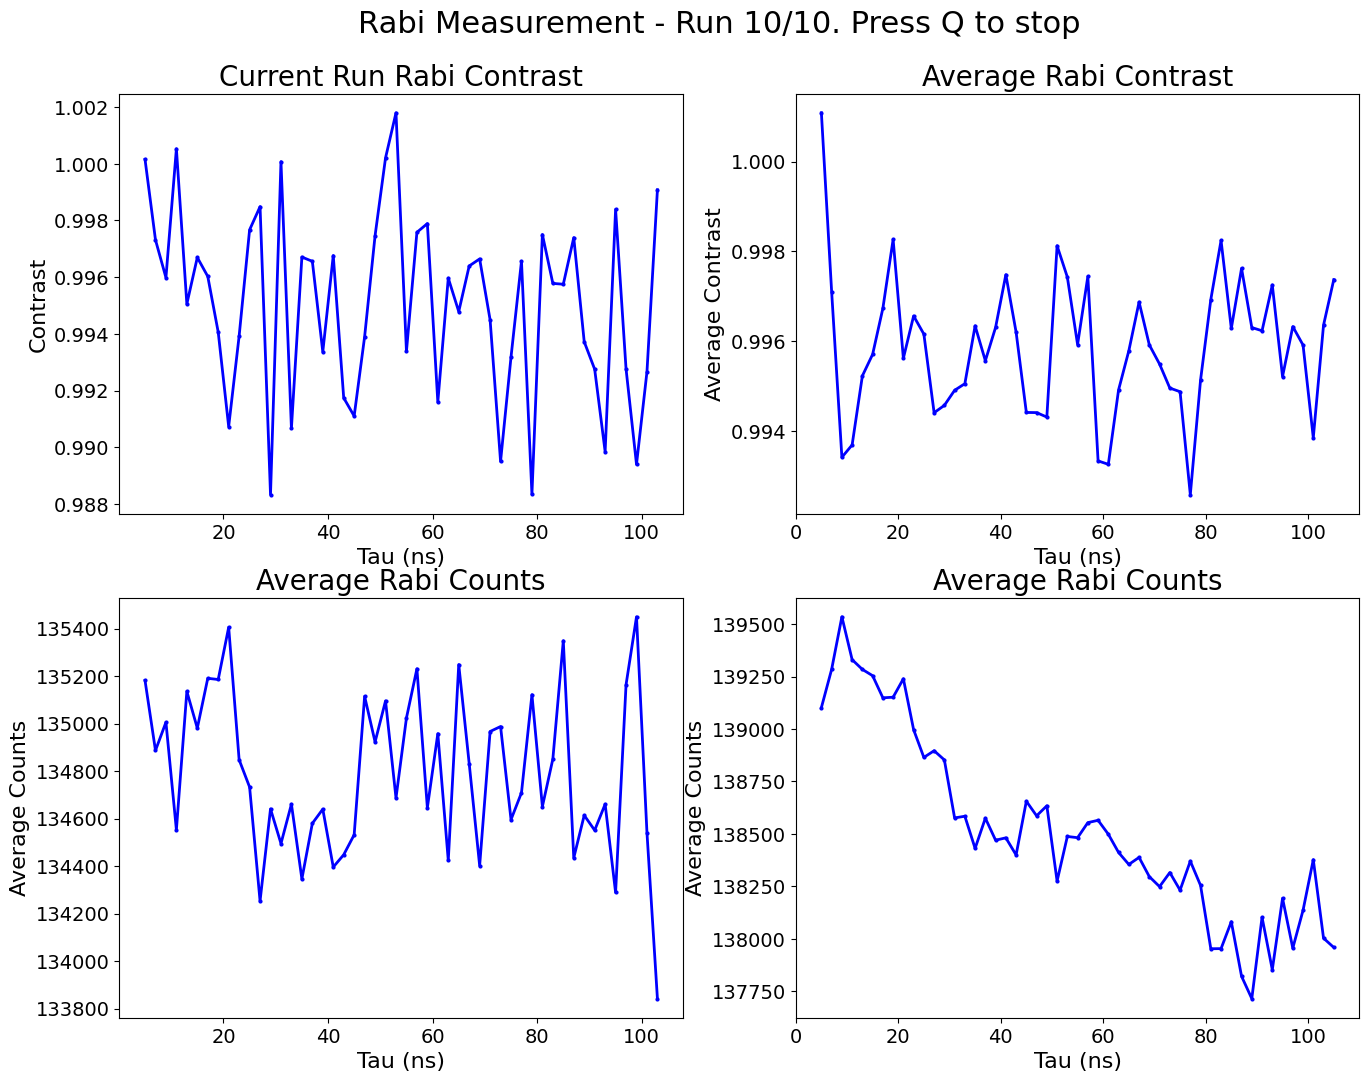

In [48]:
rabi_config = {
    # Measurement parameters
    'scale': 8,
    'samples_per_axis': 201,
    'position':[80,175], # [x,y] position to fix the beam at
    'freq': 1.69e9, # in Hz. 
    'mw_power':0, # in dBm
    'num_avgs':10,
    
    # Other parameters
    'pulse_sequence': 'rabi',
    'aomvolt': 0.5,
    'pulsenum': 30000,
    'init_t': 7000, # All times are in NANOSeconds!!!
    'wait_t': 700,
    'delay_t': 950,
    'readout_t': 3000,
    'seqplot': False,
    'extra_delay': 70,
}
odmr.update_config(**rabi_config)

tau_range = np.linspace(5, 5 + 2 * 50, num=51) # in ns. Start and step taus are given here.
taus, avg_contrast, all_contrast, avg_counts, all_counts = odmr.run_rabi_sweep(tau_range)

### Now just plot and fit the data

[ 3.14923440e-03  1.64317925e+01 -1.45457776e+00  9.95868106e-01
  4.65653082e+01]


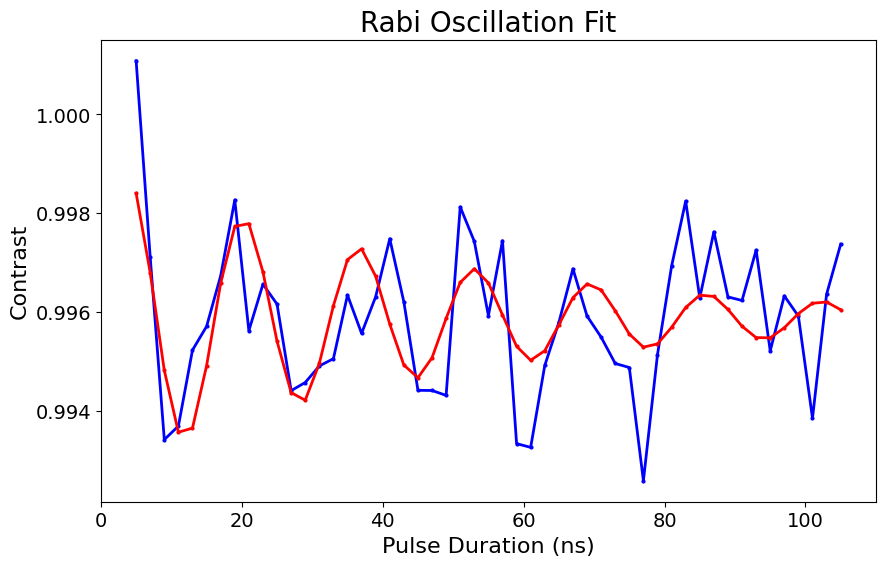

In [56]:
def fit_func(x, a, b, c, d, T2):
    return a * np.cos(2*np.pi * x /b + c) * np.exp(-x/T2) + d

from scipy.optimize import curve_fit
popt, pcov = curve_fit(fit_func, tau_range, avg_contrast, p0=[0.02, 15, 0, 1, 40])
print(popt)

fig, ax = plt.subplots(figsize=(10,6))
plot_this_xy(tau_range, avg_contrast, ax, title='Rabi Oscillation', xlabel='Pulse Duration (ns)', ylabel='Contrast', color='blue', marker='o', linestyle='-')
plot_this_xy(tau_range, fit_func(tau_range, *popt), ax, title='Rabi Oscillation Fit', xlabel='Pulse Duration (ns)', ylabel='Contrast', color='red', marker='o', linestyle='-')
plt.show()